In [3]:
import pandas as pd
import numpy as np
import transformers
import torch
import nltk
from nltk.corpus import stopwords

In [29]:
df = pd.read_csv('wod_fortime_median.csv')
df.head()

,date,wod,man_setting,woman_setting,median_record_seconds
0,2025-06-03,For time: 30 deadlifts 20 hang squat cleans 10...,205 lb,145 lb,462.5
1,2025-06-02,"For time: 1,600/2,000-meter row Every 90 secon...",NaN,NaN,797.5
2,2025-05-30,Elizabeth 21-15-9 reps for time of: Cleans Rin...,135 lb,95 lb,443.0
3,2025-05-26,Murph For time: Run 1 mile 100 pull-ups 200 pu...,NaN,NaN,2926.0
4,2025-05-23,5 rounds for time of: 15 GHD back extensions 2...,NaN,NaN,820.0


In [30]:
df['wod'].duplicated(keep=False).sum()

175

In [31]:
df[df["wod"]=='Karen For time: 150 wall-ball shots']

,date,wod,man_setting,woman_setting,median_record_seconds
15,2025-04-23,Karen For time: 150 wall-ball shots,20-lb ball to 10-foot target,14-lb ball to 9-foot target,519.5
86,2024-10-23,Karen For time: 150 wall-ball shots,20-lb medicine ball to 10-foot target,14-lb medicine ball to 9-foot target,515.0
428,2022-04-03,Karen For time: 150 wall-ball shots,20-lb ball to 10-ft target,14-lb ball to 9-ft target,495.0
538,2021-06-03,Karen For time: 150 wall-ball shots,20-lb. ball to 10-ft. target,14-lb. ball to 9-ft. target,474.0
691,2019-12-19,Karen For time: 150 wall-ball shots,20-lb. ball to 10-ft. target,14-lb. ball to 9-ft. target,511.0


In [ ]:
df['median_record_seconds'] = df.groupby('wod')['median_record_seconds'].transform('median')
df[df["wod"]=='Karen For time: 150 wall-ball shots']

,date,wod,man_setting,woman_setting,median_record_seconds
15,2025-04-23,Karen For time: 150 wall-ball shots,20-lb ball to 10-foot target,14-lb ball to 9-foot target,511.0
86,2024-10-23,Karen For time: 150 wall-ball shots,20-lb medicine ball to 10-foot target,14-lb medicine ball to 9-foot target,511.0
428,2022-04-03,Karen For time: 150 wall-ball shots,20-lb ball to 10-ft target,14-lb ball to 9-ft target,511.0
538,2021-06-03,Karen For time: 150 wall-ball shots,20-lb. ball to 10-ft. target,14-lb. ball to 9-ft. target,511.0
691,2019-12-19,Karen For time: 150 wall-ball shots,20-lb. ball to 10-ft. target,14-lb. ball to 9-ft. target,511.0


In [36]:
df.drop_duplicates(subset=['wod'], inplace=True, keep='first')
df.reset_index(drop=True, inplace=True)
df['wod'].duplicated(keep=False).sum()
df.shape

(684, 5)

In [43]:
X = df.drop(columns=['date', 'median_record_seconds'])
y = df['median_record_seconds']
X.shape, y.shape

((684, 3), (684,))

In [44]:
text_combined = []

print('Combining all text features...')

for (i, row) in X.iterrows():
  combined = ''

  for text_col in ['wod', 'man_setting', 'woman_setting']:
    if pd.isna(row[text_col]):
      continue
    combined += (str(row[text_col]) + ' [unsused1]')

  text_combined.append(combined)

assert(len(text_combined) == len(X))

print('Done')

Combining all text features...
Done


In [45]:
X = X.drop(columns=['wod', 'man_setting', 'woman_setting'], axis=1, inplace=False)
X.insert(0, 'wod_info', text_combined)

with pd.option_context('display.max_colwidth', None):
  display(X.head())

,wod_info
0,For time: 30 deadlifts 20 hang squat cleans 10 shoulder-to-overheads [unsused1]205 lb [unsused1]145 lb [unsused1]
1,"For time: 1,600/2,000-meter row Every 90 seconds, including the start, perform 3 wall walks until you complete the row. [unsused1]"
2,Elizabeth 21-15-9 reps for time of: Cleans Ring dips [unsused1]135 lb [unsused1]95 lb [unsused1]
3,"Murph For time: Run 1 mile 100 pull-ups 200 push-ups 300 air squats Run 1 mile Partition the pull-ups, push-ups, and squats as needed. If you’ve got a 14/20-lb vest or body armor, wear it. [unsused1]"
4,5 rounds for time of: 15 GHD back extensions 25 AbMat sit-ups 50 double-unders [unsused1]


In [ ]:
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

encoded_corpus = tokenizer(text=X['wod_info'].tolist(),
                            add_special_tokens=True,
                            padding='max_length',
                            truncation='longest_first',
                            max_length=512,
                            return_attention_mask=True)



tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [47]:
input_ids = encoded_corpus['input_ids']
attention_mask = encoded_corpus['attention_mask']

In [48]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    input_ids, y, test_size=0.2, random_state=42
)
X_train_mask, X_test_mask, _, _ = train_test_split(
    attention_mask, y, test_size=0.2, random_state=42
)

In [49]:
from sklearn.preprocessing import StandardScaler
import numpy as np

scaler = StandardScaler()

y_train = np.log1p(y_train)
y_test = np.log1p(y_test)

scaler.fit(y_train.values.reshape(-1, 1))
y_train = scaler.transform(y_train.values.reshape(-1, 1))
y_test = scaler.transform(y_test.values.reshape(-1, 1))

-4.026841829719032e-16
1.0


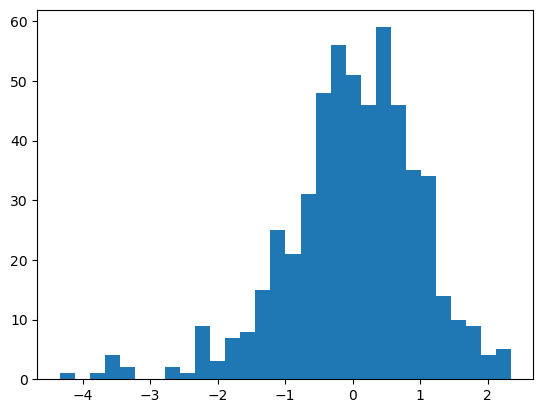

In [50]:
import matplotlib.pyplot as plt

plt.hist(y_train,bins=30)
print(y_train.mean())
print(y_train.std())

In [51]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 32

def create_dataloaders(inputs, masks, labels, batch_size, train=True):
    input_tensor = torch.tensor(inputs)
    mask_tensor = torch.tensor(masks)
    labels_tensor = torch.tensor(labels)
    dataset = TensorDataset(input_tensor, mask_tensor,
                            labels_tensor)
    if train:
        sampler = RandomSampler(dataset)
    else:
        sampler = SequentialSampler(dataset)

    dataloader = DataLoader(dataset, batch_size=batch_size, sampler=sampler)
    return dataloader

y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

train_dataloader = create_dataloaders(X_train, X_train_mask,
                                      y_train, batch_size, train=True)
test_dataloader = create_dataloaders(X_test, X_test_mask,
                                     y_test, batch_size, train=False)

In [52]:
import torch.nn as nn
from transformers import BertModel

class BertRegressor(nn.Module):

    def __init__(self, drop_rate=0.2, freeze_Bert=False):

        super(BertRegressor, self).__init__()

        self.Bert = BertModel.from_pretrained('bert-base-uncased')

        if freeze_Bert:
            for param in self.Bert.parameters():
                param.requires_grad = False

        self.regressor = nn.Sequential(
            nn.Dropout(drop_rate),
            nn.Linear(768, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
            )

    def forward(self, input_ids, attention_masks):

        outputs = self.Bert(input_ids, attention_masks)
        class_label_output = outputs.pooler_output
        outputs = self.regressor(class_label_output)
        return outputs

model = BertRegressor(drop_rate=0.2)

In [ ]:
from transformers import get_linear_schedule_with_warmup


epochs = 10
total_steps = len(train_dataloader) * epochs

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, eps=1e-8)

scheduler = get_linear_schedule_with_warmup(optimizer,
                 num_warmup_steps=0, num_training_steps=total_steps)

loss_function = nn.MSELoss()

In [ ]:
def r2_score(outputs, labels):
    labels_mean = torch.mean(labels)
    ss_tot = torch.sum((labels - labels_mean) ** 2)
    ss_res = torch.sum((labels - outputs) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2

def evaluate(model, loss_function, test_dataloader, device):

    model.eval()

    test_loss, test_r2 = [], []

    for batch in test_dataloader:
        batch_inputs, batch_masks, batch_labels = \
                                  tuple(b.to(device) for b in batch)
        with torch.no_grad():
            outputs = model(batch_inputs, batch_masks)

        loss = loss_function(outputs, batch_labels)
        test_loss.append(loss.item())

        r2 = r2_score(outputs, batch_labels)
        test_r2.append(r2.item())

    return test_loss, test_r2

In [ ]:
from torch.nn.utils.clip_grad import clip_grad_norm_

def train(model, optimizer, scheduler, loss_function, epochs,
          train_dataloader, device, test_dataloader, clip_value=2):

    train_losses = []
    validation_losses = []
    r2_scores = []

    for epoch in range(epochs):
        print('Epoch: ',epoch+1)
        print("-----")
        print('Training...')
        best_loss = 1e10
        model.train()
        total_loss = 0
        for step, batch in enumerate(train_dataloader):

            batch_inputs, batch_masks, batch_labels = \
                               tuple(b.to(device) for b in batch)

            model.zero_grad()

            outputs = model(batch_inputs, batch_masks)

            loss = loss_function(outputs.squeeze(),
                             batch_labels.squeeze())
            total_loss += loss.item()

            loss.backward()
            clip_grad_norm_(model.parameters(), clip_value)
            optimizer.step()
            scheduler.step()

            if step % 100 == 0 and not step == 0:
              print(f'Batch: {step}/{len(train_dataloader)}')

        avg_train_loss = total_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)

        print(f'Epoch{epoch+1} Average Training Loss: {avg_train_loss:>5f}')

        print('\nValidaion...')

        test_loss, test_r2 = evaluate(model, loss_function, test_dataloader, device)

        avg_test_loss = sum(test_loss) / len(test_loss)
        avg_test_r2 = sum(test_r2) / len(test_r2)

        validation_losses.append(avg_test_loss)
        r2_scores.append(avg_test_r2)

        print(f'Epoch {epoch+1} Average Test Loss: {avg_test_loss:>5f}')
        print(f'Epoch {epoch+1} Average Test R2: {avg_test_r2:>5f}\n')

    return model, train_losses, validation_losses, r2_scores

In [ ]:
import torch
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU.")
else:
    print("No GPU available, using the CPU instead.")
    device = torch.device("cpu")
model.to(device)

In [ ]:
model, train_losses, validation_losses, r2_scores = train(model, optimizer, scheduler, loss_function, epochs,
              train_dataloader, device, test_dataloader, clip_value=2.0)

In [ ]:
plt.plot(train_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.plot(r2_scores, label='R2 Score')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()